**Recopiez ce notebook et envoyez-moi le lien à la fin de la séance.**

Votre **nom**:


Votre **prénom**:


*Observations/commentaires éventuels de l'étudiant à l'enseignant*:




# Neural Networks

*Emmanuel Viennet, 2019-12-15, 2022-01-11*

## Application to digit images recognition


Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)`` that
returns the ``output``.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``





In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # SciPy module that loads mat-files

# Define the neural network


Let’s define a fully connected neural network with one hidden layer:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ImWidth  = 28 # input image size
ImHeight = 28
N1 = 100 # neurons on first hidden layer
NbClass= 10 # neurons on output layer

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(ImWidth*ImHeight, N1)
        self.fc2 = nn.Linear(N1, NbClass)        
    
    def forward(self, x):
        x = torch.flatten(x, 1) # the input is a 2d image        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


## Explanations and experiments

Before learning this network, let's experiment a bit with PyTorch.

You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [ ]:
params = list(net.parameters())
print("network parameters:")
for i in range(len(params)):
    print('params[{}] size={}'.format(i, params[i].size()))

network parameters:
params[0] size=torch.Size([100, 784])
params[1] size=torch.Size([100])
params[2] size=torch.Size([10, 100])
params[3] size=torch.Size([10])


**Question**: can you interpret these parameters sizes ? (what is `params[1]` ?) 

### Let try a random 28x28 input:

In [ ]:
input = torch.randn(1, ImWidth, ImHeight)
out = net(input)
print(out)

tensor([[0.5119, 0.5189, 0.6453, 0.3977, 0.3669, 0.4250, 0.5132, 0.5839, 0.5632,
         0.5761]], grad_fn=<SigmoidBackward0>)


**Question**: what is the dimension of the output (printed above) ? What is the class associated by our untrained network to this random input image ?

### Zero the gradient buffers of all parameters and backprops with random gradients:



In [ ]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
loss functions https://pytorch.org/docs/nn.html#loss-functions under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:

</div>

In [ ]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
print(target)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor([[ 1.2824,  0.2616, -0.4577,  1.0668,  0.2965,  1.3334,  0.3961,  0.4971,
          2.3507,  0.7872]])
tensor(0.6415, grad_fn=<MseLossBackward0>)


As you can see, the loss is a tensor, which allows PyTorch (autograd) to automatically compute its gradient.

### Gradient backpropagation

To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at fc1's bias
gradients before and after the backward.



In [ ]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('fc1.bias.grad before backward')
print(net.fc1.bias.grad)

loss.backward()

print('fc1.bias.grad after backward')
print(net.fc1.bias.grad)

fc1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
fc1.bias.grad after backward
tensor([ 0.0000, -0.0076,  0.0063,  0.0000,  0.0028,  0.0000,  0.0000,  0.0018,
         0.0000,  0.0108,  0.0000, -0.0058,  0.0009,  0.0000,  0.0020,  0.0000,
         0.0059, -0.0049, -0.0083, -0.0018,  0.0000,  0.0000,  0.0129,  0.0085,
        -0.0011, -0.0038,  0.0041,  0.0000,  0.0025, -0.0012,  0.0000, -0.0056,
         0.0000,  0.0000, -0.0011, -0.0078, -0.0013,  0.0000,  0.0000, -0.0124,
         0.0000,  0.0000, -0.0044,  0.0052,  0.0000, -0.0004,  0.0000,  0.0038,
         0.0029,  0.

Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is here https://pytorch.org/docs/nn.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=1) # learning_rate = 1.0

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

Observe how gradient buffers had to be manually set to zero using
``optimizer.zero_grad()``. This is because gradients are accumulated
as explained before.



# Experiment on MNIST digits

Our network retina is 28x28

## Load and prepare data

La cellule suivante permet de lire des données depuis votre Google Drive: il vous faut adapter le chemin pour indiquer le dossier dans lequel vous aurez placé vos données. Lors de la première exécution, vous devrez autoriser ce code à accéder à votre drive.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# On peut utiliser !ls pour explorer son drive...
# ! ls 

Mounted at /content/drive


In [ ]:
import os

# Le fichier des données (images des chiffres) est à récupérer ici
# https://drive.google.com/file/d/1L9JhlevAsKlOGZImjY4b6ny4_GX_ZyUv/view?usp=sharing
# et à placer dans VOTRE drive pour l'utiliser.
# Ajuster le chemin ci-dessous pour le retrouver !
mnist_raw = loadmat('drive/MyDrive/Colab Notebooks/AFD-2021-22/Séance-2/mnist-original.mat')
print(mnist_raw)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Dec 19 13:46:13 2018', '__version__': '1.0', '__globals__': [], 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
      dtype=object), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}


In [ ]:
data = torch.from_numpy(mnist_raw['data'].transpose()).view((-1,1,ImWidth,ImHeight))
print(data.shape) # 70000 28x28 images
label = mnist_raw['label'].reshape(-1).astype(int)
print(label.shape)
print(label[50000:50010])

torch.Size([70000, 1, 28, 28])
(70000,)
[8 8 8 8 8 8 8 8 8 8]


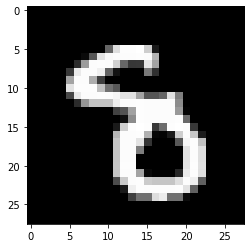

In [ ]:
plt.imshow(data[50000][0], cmap = plt.cm.gray, clim=(0, 255))

In [ ]:
# Normalization parameters, computed on all data (train+test)
data_float = data.to(torch.float)
mean_pixel = torch.mean(data_float)
std_pixel = torch.std(data_float)
print(f'mean_pixel={mean_pixel}, std_pixel={std_pixel}')

mean_pixel=33.385963439941406, std_pixel=78.65437316894531


In [ ]:
print('data size=', data.size())
X = (data_float - mean_pixel) / std_pixel
print('X size=', X.size())
print(f'mean input={torch.mean(X)}, std input={torch.std(X)}')

data size= torch.Size([70000, 1, 28, 28])
X size= torch.Size([70000, 1, 28, 28])
mean input=3.4877232213403886e-09, std input=1.0


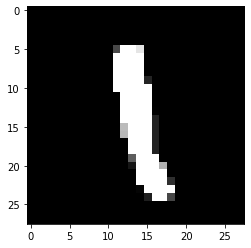

In [ ]:
plt.imshow(X[7000][0], cmap = plt.cm.gray, clim=(0, 1))

### Prepare output vectors in "one hot encoding" format
`label` are the classes `(0, 1, ..., 9)`.

In [ ]:
Y = torch.zeros([len(X), 10], dtype=torch.float)
for i in range(len(X)):
    Y[i][label[i]] = 1.

# example: 
Y[7000]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

### Shuffle the examples
During learning, the examples should be presented in a random order. 
Because if we present all the examples from class 0, then class 1, etc., the learning would not converge.

In [ ]:
# .randperm generates permutations:
torch.randperm(10)

tensor([2, 9, 5, 3, 6, 8, 7, 1, 0, 4])

In [ ]:
# Shuffle the examples:
indices_permutes = torch.randperm(len(X))
X_perm = X[indices_permutes]
Y_perm = Y[indices_permutes]
print(X_perm.size())

torch.Size([70000, 1, 28, 28])


### Split the data in train/test sets:
In this case, we learn on 2/3 of the data, and use the remaining tier to estimate the performances.

In [ ]:
n_train = (len(X)*2)//3
X_train = X_perm[:n_train]
Y_train = Y_perm[:n_train]

X_test = X_perm[n_train:]
Y_test = Y_perm[n_train:]
print('Learning on', len(X_train), 'examples')
print('Eval     on', len(X_test), 'examples')

Learning on 46666 examples
Eval     on 23334 examples


In [ ]:
out = net(X_train[0:1])
print(out)

tensor([[0.6862, 0.4594, 0.3472, 0.6498, 0.4539, 0.6016, 0.4655, 0.4811, 0.6895,
         0.4773]], grad_fn=<SigmoidBackward0>)


In [ ]:
# The predicted class (0, 1, 2, ..., 9) is given by the index of the max:
torch.argmax(out)

tensor(8)

In [ ]:
# Get classification errors
def idx_classif_errors(Y_true, Y_pred):
    """Number of classification errors, on 2 "one hot encoded" tensors
    """
    Y_pred_cls = np.argmax(Y_pred.detach().numpy(), axis=1)
    Y_true_cls = np.argmax(Y_true.detach().numpy(), axis=1)
    return np.where(Y_pred_cls != Y_true_cls)[0]

def nb_classif_errors(Y_true, Y_pred):
    return len(idx_classif_errors(Y_true, Y_pred))

# Let's try this on the first 1000 examples:
nb_err = nb_classif_errors( Y_train[:1000], net(X_train[:1000]) ) 
print("Number of errors:", nb_err, "(", nb_err*100/1000., "%)")

Number of errors: 944 ( 94.4 %)


# Learning the Network

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=1.)
batch_size = 10
num_epochs = 36

losses = [] # record losses and error rates during learning
train_err_rates = []
test_err_rates = []

In [ ]:
# Learning loop
for epoch in range(num_epochs):
    print("starting epoch", epoch)
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[ beg_i:beg_i + batch_size, :]
        y_batch = Y_train[ beg_i:beg_i + batch_size]        
        # forward:
        outputs = net(x_batch)
        loss = criterion(outputs, y_batch)
        # reset gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
        if (beg_i//batch_size) % 1000 == 0: 
            # print cost after 1000 updates (mini-batches):
            print(beg_i, 'loss=%3.3g' % losses[-1])
    
    # Measure error rate after each epoch
    train_nb_err = nb_classif_errors( Y_train, net(X_train) ) 
    train_err_rates.append( train_nb_err*100/len(Y_train) )
    test_nb_err = nb_classif_errors( Y_test, net(X_test) ) 
    test_err_rates.append( test_nb_err*100/len(Y_test) )
    print("Nb of errors (training set):", train_nb_err, "(%3.2g%%)" % train_err_rates[-1])
    print("Nb of errors (test set):", test_nb_err, "(%3.2g%%)" % test_err_rates[-1])


print("Done.")

starting epoch 0
0 loss=0.295
10000 loss=0.00927
20000 loss=0.00554
30000 loss=0.00625
40000 loss=0.00215
Nb of errors (training set): 1948 (4.2%)
Nb of errors (test set): 1111 (4.8%)
starting epoch 1
0 loss=0.00278
10000 loss=0.00984
20000 loss=0.000268
30000 loss=0.00938
40000 loss=0.00259
Nb of errors (training set): 1379 (  3%)
Nb of errors (test set): 909 (3.9%)
starting epoch 2
0 loss=0.00281
10000 loss=0.00904
20000 loss=0.000728
30000 loss=0.00606
40000 loss=0.000187
Nb of errors (training set): 1124 (2.4%)
Nb of errors (test set): 815 (3.5%)
starting epoch 3
0 loss=0.00234
10000 loss=0.0136
20000 loss=0.000275
30000 loss=0.00313
40000 loss=0.00081
Nb of errors (training set): 949 (  2%)
Nb of errors (test set): 731 (3.1%)
starting epoch 4
0 loss=0.000447
10000 loss=0.00447
20000 loss=0.000428
30000 loss=0.000551
40000 loss=6.74e-05
Nb of errors (training set): 838 (1.8%)
Nb of errors (test set): 709 (  3%)
starting epoch 5
0 loss=0.000371
10000 loss=0.00315
20000 loss=1.43e-05

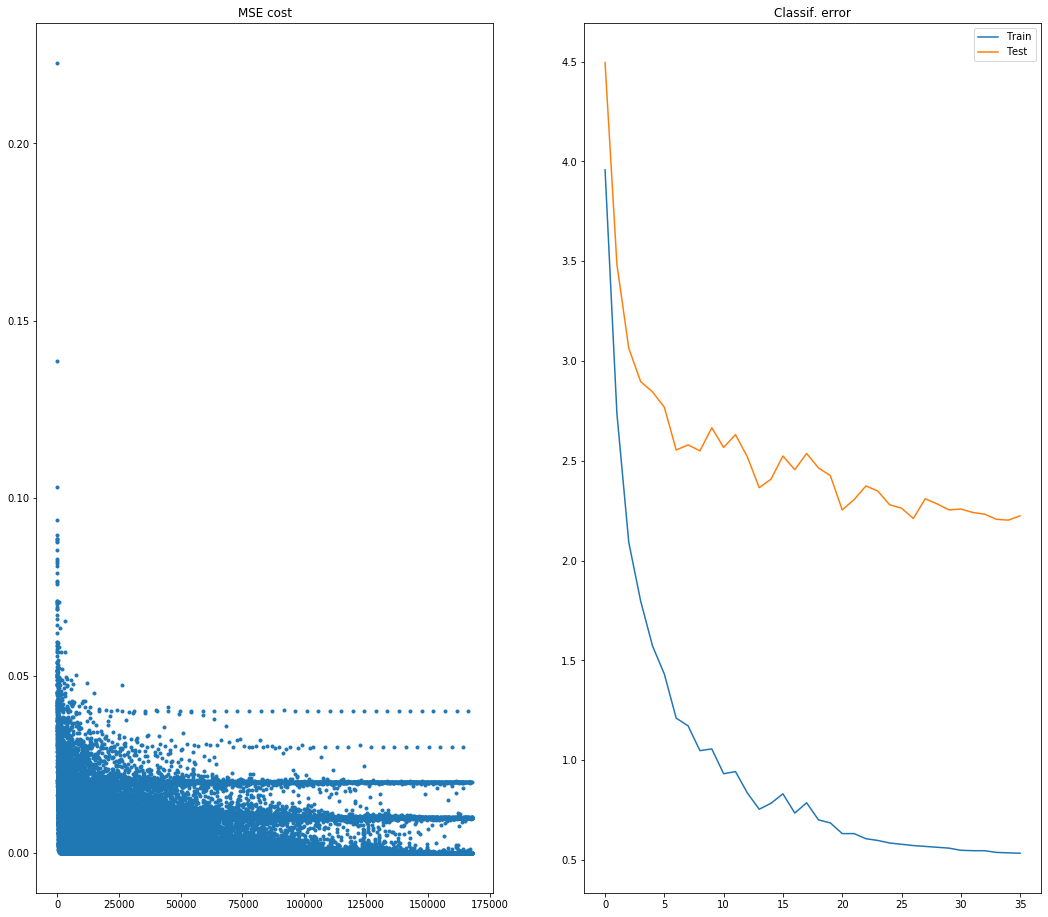

In [ ]:
plt.figure(figsize=(18, 16))
plt.subplot(1,2,1)
plt.plot(losses, linestyle='', marker='.')
plt.title('MSE cost')
plt.subplot(1,2,2)
plt.plot(train_err_rates, label="Train")
plt.plot(test_err_rates, label="Test")
plt.title('Classif. error')
jnk=plt.legend()

## Display the 12 first errors on the testing set:

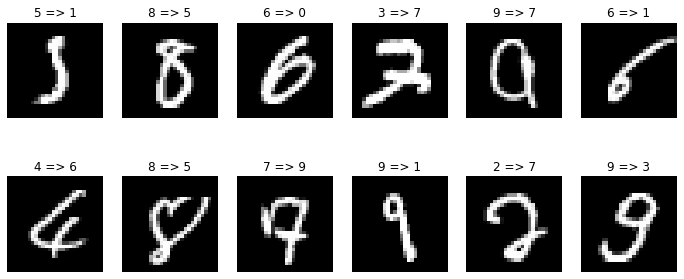

In [ ]:
Y_pred = net(X_test)
test_errors_idx = idx_classif_errors( Y_test, Y_pred )[:12]

fig = plt.figure(figsize=(12,8))
ncols = 6
nrows = len(test_errors_idx) // ncols + 1
index = 1
for i in test_errors_idx:
    plt.subplot(nrows, ncols, index)
    plt.imshow( X_test[i].reshape(ImHeight,ImWidth), cmap=plt.cm.gray)
    plt.axis('off')
    true_class = torch.argmax(Y_test[i])
    pred_class = torch.argmax(Y_pred[i])
    plt.title(f'{true_class} => {pred_class}')
    index += 1

    

# Questions 

1. What does each point on the MSE (left) graph represent ?

2. Compute and print the confusion matrix on the training test and on the test set. What classes are confused with each other ?

3. Looking at the classification error curves (right), do you think the network is underfitting or overfitting ? What could we do to enhance generalization ? Make some experiments and discuss the results.
